In [971]:
import os
import sys
sys.path.append('/Users/sookuda/data/pointing/')
import glob
import numpy
import matplotlib
#% matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize

#import opt_analy
#import plot
#import plot_3d

cos = numpy.cos
sin = numpy.sin
d2r = numpy.deg2rad
diag = numpy.diag
sqrt = numpy.sqrt
r2d = numpy.rad2deg
#opt_20190823065113

In [972]:
dir_list = [
    'opt_20190828033222'
]

hosei_path = '/Users/sookuda/data/pointing/parameter/opt_20190828033222/hosei_opt.txt'
old_kisa = numpy.loadtxt(hosei_path)

In [973]:
#file_list = ['/Users/sookuda/data/pointing/parameter/opt_20190821015311','/Users/sookuda/data/pointing/parameter/opt_20190823065113']
#file_list = ['/Users/sookuda/data/pointing/parameter/opt_20190827003007']
file_list = ['/Users/sookuda/data/pointing/parameter/opt_20190828033222']

In [975]:
ind_az = 14
ind_el = 15
ind_dx = 9
ind_dy = 10
dx_avg, dy_avg, dx_std, dy_std, *_ = process_static(file_list, sigma_clip=(3.,3.))
az_list, el_list, dx_list, dy_list = [], [], [], []
for _ in file_list:
    d = numpy.loadtxt(_ + '/process.log')
    sigma_clip=(3., 3.)
    d[:,ind_dx]=(d[:,ind_dx]-320)*0.87*(-1)
    d[:,ind_dy]=(d[:,ind_dy]-240)*0.87
    d = d[(abs(d[:,ind_dx] -dx_avg) < dx_std * sigma_clip[0]) & (abs(d[:,ind_dy] -dy_avg) < dy_std * sigma_clip[1])]
    az_list.append(d[:,ind_az])
    el_list.append(d[:,ind_el])
    dx_list.append(d[:,ind_dx])
    dy_list.append(d[:,ind_dy])    

In [974]:
def process_static(dir_list, *, sigma_clip=None, const_clip=None):
    rawdata = numpy.concatenate([numpy.loadtxt(os.path.join(_dir, 'process.log')) for _dir in dir_list])

    rawdata[:,ind_dx]=(rawdata[:,ind_dx]-320)*0.87*(-1)
    rawdata[:,ind_dy]=(rawdata[:,ind_dy]-240)*0.87

    rawdx_avg = numpy.average(rawdata[:,ind_dx])
    rawdy_avg = numpy.average(rawdata[:,ind_dy])
    rawdx_std = numpy.std(rawdata[:,ind_dx])
    rawdy_std = numpy.std(rawdata[:,ind_dy])
    rawdx_med = numpy.median(rawdata[:,ind_dx])
    rawdy_med = numpy.median(rawdata[:,ind_dy])

    if sigma_clip != None:
        x_clip, y_clip = sigma_clip
        d=rawdata[(abs(rawdata[:,ind_dx] -rawdx_med) < x_clip * rawdx_std) & (abs(rawdata[:,ind_dy] -rawdy_med) < y_clip * rawdy_std)]
    elif const_clip != None:
        x_clip, y_clip = const_clip
        d=rawdata[(abs(rawdata[:,ind_dx] -rawdx_med) < x_clip) & (abs(rawdata[:,ind_dy] -rawdy_med) < y_clip)]
    else:
        d = rawdata

    dx_avg = numpy.average(d[:,ind_dx])
    dy_avg = numpy.average(d[:,ind_dy])
    dx_std = numpy.std(d[:,ind_dx])
    dy_std = numpy.std(d[:,ind_dy])
    dx_med = numpy.median(d[:,ind_dx])
    dy_med = numpy.median(d[:,ind_dy])

    return dx_avg, dy_avg, dx_std, dy_std, dx_med, dy_med

In [976]:
az = az_list[0]
el = el_list[0]
dx = dx_list[0]
dy = dy_list[0]

In [978]:
# initial params.
kisa0 = [0.] * 24

'\n# initial params.\nkisa0 = [0.] * 24\n# Azエンコーダーオフセット (arcsec.)\nkisa0[0] = 0#50.733546644375636\n# Az オフセット (arcsec.)\nkisa0[1] = 0.\n# Az 軸の倒れ 振幅 (arcsec.)\nkisa0[2] =  0.\n# Az 軸の倒れ 位相 (deg.)\nkisa0[3] = 0.\n# Az 軸と El 軸の非直行性 (arcsec.)\n# kisa0[4] = -19.163639255053894\nkisa0[4] = 0.\n# Az 軸の倒れ 振幅 dy fitting 用 (arcsec.)\nkisa0[7] =  0.\n# Az 軸の倒れ 位相 dy fitting 用 (deg.)\nkisa0[8] = 0.\n# Az 180 deg. 周期項 振幅 dy fitting 用 (arcsec.)\nkisa0[9] = 0.   \n# Az 180 deg. 周期項 位相 dy fitting 用 (deg.)\nkisa0[10] = 0.\n# 重力・大気差 1次・光学用 (const.)\nkisa0[11] = 0.#4.174693859337004209e-01  \n# El 方向 の offset (arcsec.)\nkisa0[15] = 0.#37.623435317238425\nkisa0[22] = 0.\nkisa0[23] = 0.\n'

In [1]:
def func_x(altaz,*kisa):
    az,el = altaz
    dx_ = kisa[2] * sin(d2r(kisa[3] - az))* sin(d2r(el)) \
        + kisa[4]* sin(d2r(el)) \
        + kisa[0]* cos(d2r(el)) \
        + kisa[1] + kisa[5]*sin(2*d2r(kisa[6]-az))*sin(d2r(el))
    return dx_

def func_y(altaz,*kisa):
    az,el = altaz
    dy_ = - kisa[0] * cos(d2r(kisa[1] - az)) \
        + kisa[8] \
        + kisa[7] * numpy.array(el)*3600 - kisa[9]*cos(2*d2r(kisa[10]-az))
    return dy_

In [979]:
#kisa = scipy.optimize.leastsq(func,kisa0,args=(az,el,dx,dy))[0]

#print(numpy.array((dx,dy)).T)
kisa_x, cov = scipy.optimize.curve_fit(func_x, xdata=(az,el), ydata=dx, p0=numpy.array([*kisa0]))
kisa_y, cov = scipy.optimize.curve_fit(func_y, xdata=(az,el), ydata=dy, p0=numpy.array([*kisa0]))
#kisa_x = scipy.optimize.leastsq(fx,kisa0_x,args=(az,el,dx))[0]
#kisa_y = scipy.optimize.leastsq(fy,kisa0_y,args=(az,el,dy))[0]
#kisa_x,cor_x = scipy.optimize.curve_fit(fx, xdata=(az,el),ydata=dx, p0=numpy.array([*kisa0_x]))
#kisa_y,cor_y = scipy.optimize.curve_fit(fy, xdata=(az,el),ydata=dy, p0=numpy.array([*kisa0_y]))


/Users/sookuda/.pyenv/versions/3.5.1/lib/python3.5/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [980]:

kisa = [0.]*24

kisa[0] = kisa_x[0] + old_kisa[0]
kisa[1] = kisa_x[1] + old_kisa[1]
kisa[4] = kisa_x[4] + old_kisa[4]
kisa[11] = kisa_y[11] + old_kisa[11]
kisa[15] = kisa_y[15] + old_kisa[15]

A = abs(old_kisa[2] * cos(d2r(old_kisa[3])) + kisa_x[2] * cos(d2r(kisa_x[3])))
B = abs(old_kisa[2] * sin(d2r(old_kisa[3])) + kisa_x[2] * sin(d2r(kisa_x[3])))
amp = sqrt(A ** 2 + B ** 2)
phi = numpy.arctan(B / A)

kisa[2] = - amp
kisa[3] = - r2d(phi)

A = abs(old_kisa[7] * cos(d2r(old_kisa[8])) + kisa_y[7] * cos(d2r(kisa_y[8])))
B = abs(old_kisa[7] * sin(d2r(old_kisa[8])) + kisa_y[7] * sin(d2r(kisa_y[8])))
amp = sqrt(A ** 2 + B ** 2)
phi = numpy.arctan(B / A)

kisa[7] = - amp
kisa[8] = - r2d(phi)

A = abs(old_kisa[5] * cos(2*d2r(old_kisa[6])) + kisa_x[5] * cos(2*d2r(kisa_x[6])))
B = abs(old_kisa[5] * sin(2*d2r(old_kisa[6])) + kisa_x[5] * sin(2*d2r(kisa_x[6])))
amp = sqrt(A ** 2 + B ** 2)
phi = numpy.arctan(B / A)

kisa[5] = - amp
kisa[6] = - r2d(phi)

A = abs(old_kisa[9] * cos(2*d2r(old_kisa[10])) + kisa_y[9] * cos(2*d2r(kisa_y[10])))
B = abs(old_kisa[9] * sin(2*d2r(old_kisa[10])) + kisa_y[9] * sin(2*d2r(kisa_y[10])))
amp = sqrt(A ** 2 + B ** 2)
phi = numpy.arctan(B / A)

kisa[9] = - amp
kisa[10] = - r2d(phi)

'\nkisa[7] = kisa[2]\nkisa[8] = kisa[3]\nkisa[9] = kisa[5]\nkisa[10] = kisa[6]\n'

In [984]:
def model_dx(az, el, kisa):
        dx = kisa[2] * sin(d2r(kisa[3] - az))* sin(d2r(el)) \
        + kisa[4]* sin(d2r(el)) \
        + kisa[0]* cos(d2r(el)) \
        + kisa[1] 
        return dx


def model_dy(az, el, kisa):
    dy =  - kisa[7] * cos(d2r(kisa[8] - az)) \
        + kisa[15] \
        + kisa[11] * numpy.array(el) *3600. 
    return dy


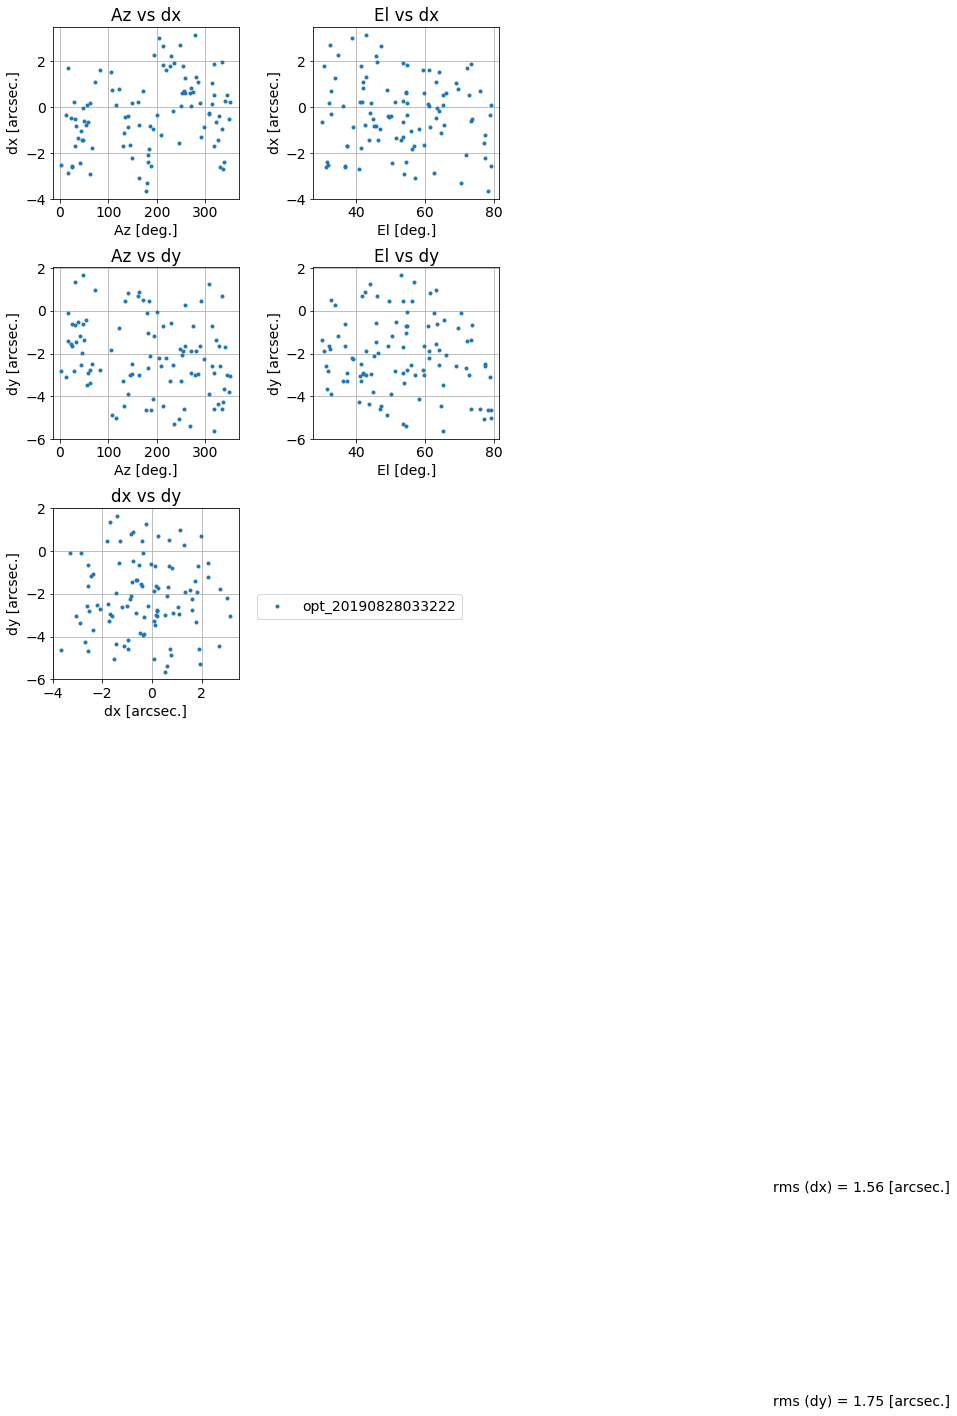

In [985]:

new_dx = dx
new_dy = dy

nrow = 3
ncol = 2
nax = ncol * nrow
figsize = (ncol * 4, nrow * 4)

fig = plt.figure(figsize=figsize)
fig.subplots_adjust(wspace=0.4, hspace=0.4)
ax = [fig.add_subplot(nrow, ncol, i+1) for i in range(nax-1)]

matplotlib.rcParams['savefig.dpi'] = 200
matplotlib.rcParams['font.size'] = 14

ax[0].plot(az, new_dx, '.', label='diff')
#ax[0].plot(az_list[1], dx_list[1], '.', label='diff')
ax[1].plot(el, new_dx, '.', label='diff')
#ax[1].plot(el_list[1], dx_list[1], '.', label='diff')
ax[2].plot(az, new_dy, '.', label='diff')
ax[3].plot(el, new_dy, '.', label='diff')
#ax[2].plot(az_list[1], dy_list[1], '.', label='diff')
#ax[3].plot(el_list[1], dy_list[1], '.', label='diff')
ax[4].plot(new_dx, new_dy, '.', label='diff')

'''
ax[0].plot(az, func_x_1((az, el), *old_kisa), '.',c='r')
ax[0].plot(az, func_x_2((az, el), *old_kisa), '.',c='g')
ax[0].plot(az, func_x_3((az, el), *old_kisa), '.',c='gray')
ax[0].plot(az, func_x_4((az, el), *old_kisa), '.',c='k')
ax[0].plot(az, func_x_5((az, el), *old_kisa), '.',c='c')
ax[2].plot(az, func_y_1((az, el), *old_kisa), '.')
ax[2].plot(az, func_y_2((az, el), *old_kisa), '.')
ax[2].plot(az, func_y_3((az, el), *old_kisa), '.')
ax[2].plot(az, func_y_4((az, el), *old_kisa), '.')
'''
ax[0].set_xlabel('Az [deg.]')
ax[0].set_ylabel('dx [arcsec.]')
ax[0].set_title('Az vs dx')

ax[1].set_xlabel('El [deg.]')
ax[1].set_ylabel('dx [arcsec.]')
ax[1].set_title('El vs dx')

ax[2].set_xlabel('Az [deg.]')
ax[2].set_ylabel('dy [arcsec.]')
ax[2].set_title('Az vs dy')

ax[3].set_xlabel('El [deg.]')
ax[3].set_ylabel('dy [arcsec.]')
ax[3].set_title('El vs dy')

ax[4].set_xlabel('dx [arcsec.]')
ax[4].set_ylabel('dy [arcsec.]')
ax[4].set_title('dx vs dy')

[_ax.grid() for _ax in ax]
# [_ax.legend() for _ax in ax]

if len(dir_list) < 8:
    tbl_loc = 'lower center'
    legend_loc = (1.1, 0.35)
else:
    tbl_loc = 'bottom'
    legend_loc = (1.1, 0.02)
ax[4].legend(labels=dir_list, loc=legend_loc)

ax[4].text(25, -30., 'rms (dx) = {:.2f} [arcsec.]'.format(numpy.std(new_dx)), size=14)
ax[4].text(25, -40., 'rms (dy) = {:.2f} [arcsec.]'.format(numpy.std(new_dy)), size=14)

plt.show()

#### F = numpy.fft.fft(func_x((az, el), *kisa))
'''
sample_freq = fftpack.fftfreq(func_x_1((az, el), *kisa_x)[:].size, d=step)
y_fft = fftpack.fft(ydata[:])
pidxs = np.where(sample_freq > 0)
freqs, power = sample_freq[pidxs], np.abs(y_fft)[pidxs]
freq = freqs[power.argmax()]
'''
print(type(F), F.dtype)
print(F) # FFT結果
F_abs = numpy.abs(F)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlim([0.5,1.5])
ax.set_ylim([35.45,35.48])
#plt.plot(F_abs)

F_abs_amp = F_abs / len(az) * 2 # 交流成分はデータ数で割って2倍する
F_abs_amp[0] = F_abs_amp[0] / 2 # 直流成分（今回は扱わないけど）は2倍不要
plt.plot(F_abs_amp[:int(len(az)/2)+1])

<class 'numpy.ndarray'> complex128
[-3.78125414 +0.00000000e+00j  0.83522740 +2.10778301e+01j
 -0.51324132 +4.69368980e-01j  0.20698936 +5.63744972e-02j
  0.28796805 -1.16055373e+00j  0.66358468 +6.89926467e-01j
 -0.01114150 -5.20733578e-01j -0.05312333 +4.86731016e-01j
 -0.34127602 -1.98095167e-01j  0.44335782 +9.55739574e-02j
 -0.42121504 +1.41026979e-01j -0.08594172 -1.99406319e-01j
 -0.26058293 -3.34052211e-01j  0.07724247 -5.72157985e-01j
  0.26405351 -4.91365696e-02j  0.25269784 -1.84065492e-01j
 -0.02722859 +1.65950190e-02j -0.04838099 -1.18813471e-01j
 -0.10710439 -2.93786099e-01j  0.04458032 -3.71525325e-01j
  0.64937899 +4.49704110e-02j  0.01974643 +4.22187050e-02j
  0.70315558 +6.05276571e-01j -0.29331514 +2.23362885e-01j
  0.14336313 +4.21729982e-01j -0.23431974 +5.09817884e-02j
 -0.38034562 -1.04868771e-01j  0.02552547 -5.25742140e-02j
 -0.37165503 -4.11489672e-02j -0.24892004 -6.82904261e-01j
  0.76410255 -2.77975432e-01j  0.10454080 -1.59634218e-03j
  0.90157534 -1.21195

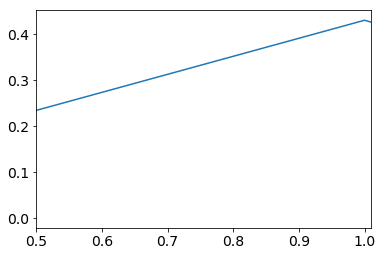

In [986]:
F = numpy.fft.fft(func_y_1((az, el), *kisa_y))
'''
sample_freq = fftpack.fftfreq(func_x_1((az, el), *kisa_x)[:].size, d=step)
y_fft = fftpack.fft(ydata[:])
pidxs = np.where(sample_freq > 0)
freqs, power = sample_freq[pidxs], np.abs(y_fft)[pidxs]
freq = freqs[power.argmax()]
'''
print(type(F), F.dtype)
print(F) # FFT結果
F_abs = numpy.abs(F)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlim([0.5,1.01])
#ax.set_ylim([35.45,35.48])
#plt.plot(F_abs)

F_abs_amp = F_abs / len(az) * 2 # 交流成分はデータ数で割って2倍する
F_abs_amp[0] = F_abs_amp[0] / 2 # 直流成分（今回は扱わないけど）は2倍不要
plt.plot(F_abs_amp[:int(len(az)/2)+1])

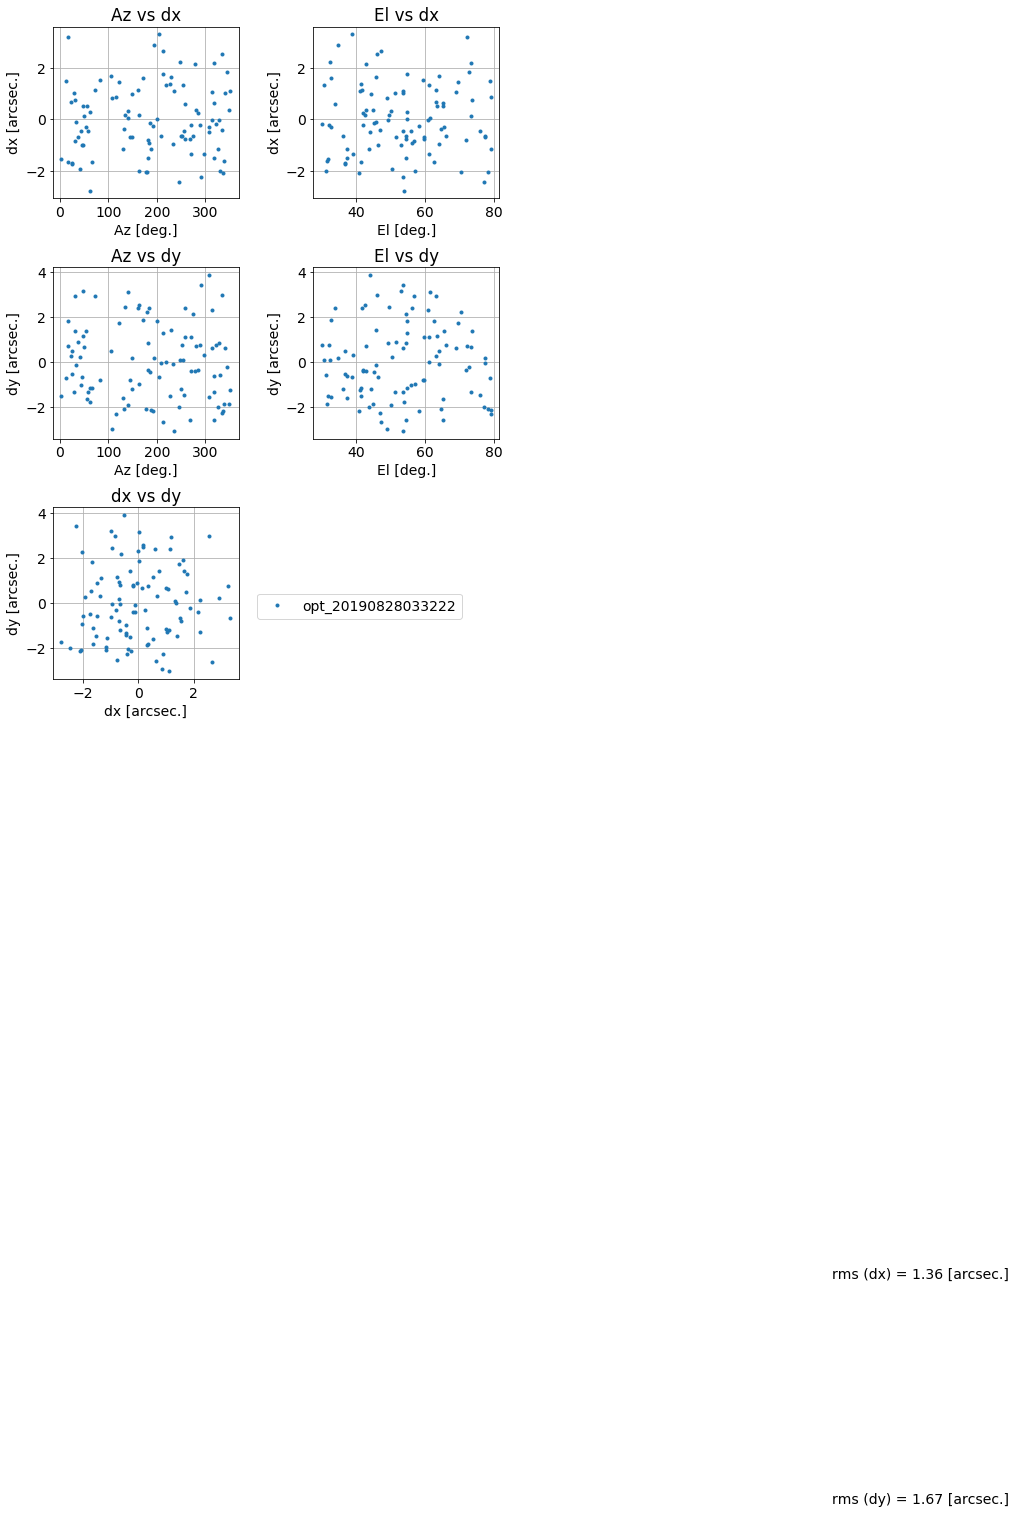

In [987]:

new_dx = dx-func_x((az, el), *kisa_x)
new_dy = dy-func_y((az, el), *kisa_y)

#new_dx = dx - model_dx(az, el, kisa_x)
#new_dy = dy - model_dy(az, el, kisa_y)

nrow = 3
ncol = 2
nax = ncol * nrow
figsize = (ncol * 4, nrow * 4)

fig = plt.figure(figsize=figsize)
fig.subplots_adjust(wspace=0.4, hspace=0.4)
ax = [fig.add_subplot(nrow, ncol, i+1) for i in range(nax-1)]

matplotlib.rcParams['savefig.dpi'] = 200
matplotlib.rcParams['font.size'] = 14

ax[0].plot(az, new_dx, '.', label='diff')
ax[1].plot(el, new_dx, '.', label='diff')
ax[2].plot(az, new_dy, '.', label='diff')
ax[3].plot(el, new_dy, '.', label='diff')
ax[4].plot(new_dx, new_dy, '.', label='diff')

#ax[0].plot(az, func_x_5((az, el), *kisa_x), '.')
#ax[2].plot(az, func_y_4((az, el), *kisa_y), '.')

ax[0].set_xlabel('Az [deg.]')
ax[0].set_ylabel('dx [arcsec.]')
ax[0].set_title('Az vs dx')

ax[1].set_xlabel('El [deg.]')
ax[1].set_ylabel('dx [arcsec.]')
ax[1].set_title('El vs dx')

ax[2].set_xlabel('Az [deg.]')
ax[2].set_ylabel('dy [arcsec.]')
ax[2].set_title('Az vs dy')

ax[3].set_xlabel('El [deg.]')
ax[3].set_ylabel('dy [arcsec.]')
ax[3].set_title('El vs dy')

ax[4].set_xlabel('dx [arcsec.]')
ax[4].set_ylabel('dy [arcsec.]')
ax[4].set_title('dx vs dy')

[_ax.grid() for _ax in ax]
# [_ax.legend() for _ax in ax]

if len(dir_list) < 8:
    tbl_loc = 'lower center'
    legend_loc = (1.1, 0.35)
else:
    tbl_loc = 'bottom'
    legend_loc = (1.1, 0.02)
ax[4].legend(labels=dir_list, loc=legend_loc)

ax[4].text(25, -30., 'rms (dx) = {:.2f} [arcsec.]'.format(numpy.std(new_dx)), size=14)
ax[4].text(25, -40., 'rms (dy) = {:.2f} [arcsec.]'.format(numpy.std(new_dy)), size=14)

plt.show()


In [988]:
kisa

[5314.6079810399769,
 377.94958297175617,
 -24.703903273544192,
 -16.112548820572442,
 18.911462335489286,
 -2.9274081393268636,
 -45.220079588267531,
 -27.684562182919592,
 -24.217995275801336,
 -1.502864123549928,
 -0.87942693667452687,
 -0.091645827902815405,
 0.0,
 0.0,
 0.0,
 6243.7644358794432,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [989]:

print('--- 前回の hosei.txt')
old = [float(_) for _ in open(hosei_path)]
for j, i in enumerate(old):
    print('{0}      :{1}'.format(j, round(float(i), 2)))
print('--- 新しい hosei.txt')
for i, j, ind in zip(kisa, old, range(24)):
    print('{0}      :{1}'.format(ind, i - float(j)))
print('--- diff')
for j, i in enumerate(kisa):
    print('{0}       :{1}'.format(j, i))
print('---')


--- 前回の hosei.txt
0      :5311.61
1      :382.82
2      :-25.48
3      :-15.88
4      :15.22
5      :-3.65
6      :-29.5
7      :-27.9
8      :-25.05
9      :-1.34
10      :-7.44
11      :-0.09
12      :0.0
13      :0.0
14      :0.0
15      :6244.52
16      :0.0
17      :0.0
18      :0.0
19      :0.0
20      :0.0
21      :0.0
22      :0.0
23      :0.0
--- 新しい hosei.txt
0      :2.9971412356781
1      :-4.873131353759447
2      :0.780389249191181
3      :-0.23462641697387632
4      :3.6887218459902034
5      :0.7235432537318536
6      :-15.721592526585766
7      :0.21710370728413153
8      :0.8349199836404217
9      :-0.16748668410329604
10      :6.561056562709615
11      :-7.155602692529572e-06
12      :0.0
13      :0.0
14      :0.0
15      :-0.7563999804515333
16      :0.0
17      :0.0
18      :0.0
19      :0.0
20      :0.0
21      :0.0
22      :0.0
23      :0.0
--- diff
0       :5314.607981039977
1       :377.9495829717562
2       :-24.703903273544192
3       :-16.112548820572442
4   

In [990]:
old_kisa

array([  5.31161084e+03,   3.82822714e+02,  -2.54842925e+01,
        -1.58779224e+01,   1.52227405e+01,  -3.65095139e+00,
        -2.94984871e+01,  -2.79016659e+01,  -2.50529153e+01,
        -1.33537744e+00,  -7.44048350e+00,  -9.16386723e-02,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         6.24452084e+03,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00])